In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.cluster import KMeans
from os import listdir
import path

In [4]:
print(listdir('../input'))

['ecommerce-data']


Reading the data and checking how many features and entries it has

In [5]:
data = pd.read_csv('../input/ecommerce-data/data.csv', encoding='ISO-8859-1')
print(data.shape)

(541909, 8)


Checking first 5 rows of data for checking the available features

In [6]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Here we can see for the first five rows we have same invoice number and customer id, suggesting that the customer shopped multiple item on the same invoice on 12th Jan 2010. We know the products are different as all have different stock code, description and unit price.

Checking for null values in the data

In [7]:
Null_values = data.isnull().sum()/data.shape[0] * 100
print(Null_values)

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64


Here we see 24.9% of customer id's are missing, along with 0.26% description of the product

Checking how many customer id's that are missing have description also missing

In [8]:
print(data[data.CustomerID.isnull()].shape[0])
print(data[data.CustomerID.isnull()].Description.isnull().value_counts())

135080
Description
False    133626
True       1454
Name: count, dtype: int64


The above description shows that out of 135080 missing customer ids 1454 have no description and remaining 133626 have a description.

Let's see how many have unit price also missing.

In [9]:
print(data[data.CustomerID.isnull()].UnitPrice.isnull().value_counts())

UnitPrice
False    135080
Name: count, dtype: int64


This shows that the unit price for all the customer id's with null value is present.

Now let's see what is happening with the missing customer id. As this could lead us to scams.

In [10]:
data[data.CustomerID.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


we can see that row 622 has 56 quantity with 0.00 unit price, which seems fishy.

Let's check for few more details.

In [11]:
data[data.CustomerID.isnull()].describe()

,Quantity,UnitPrice,CustomerID
count,135080.000000,135080.000000,0.0
mean,1.995573,8.076577,NaN
std,66.696153,151.900816,NaN
min,-9600.000000,-11062.060000,NaN
25%,1.000000,1.630000,NaN
50%,1.000000,3.290000,NaN
75%,3.000000,5.450000,NaN
max,5568.000000,17836.460000,NaN


We can see with null customer id the quantities and unit price shows outliers. Next we will see the stats where customer id is present.

In [12]:
data[data.CustomerID.isnull() == False].describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


There seems to be something wrong with the min quantity also. Why do we have min quantity in negative? Is it integer overflow? or some other issue?

Let's check all the rows where the order quantity is in negative.

In [13]:
data[data.Quantity < 0].value_counts()


InvoiceNo  StockCode  Description                         Quantity  InvoiceDate       UnitPrice  CustomerID  Country       
C543611    82483      WOOD 2 DRAWER CABINET WHITE FINISH  -1        2/10/2011 14:38   4.95       17850.0     United Kingdom    4
C538341    22976      CIRCUS PARADE CHILDRENS EGG CUP     -12       12/10/2010 14:03  1.25       15514.0     United Kingdom    3
           22730      ALARM CLOCK BAKELIKE IVORY          -1        12/10/2010 14:03  3.75       15514.0     United Kingdom    3
           22725      ALARM CLOCK BAKELIKE CHOCOLATE      -1        12/10/2010 14:03  3.75       15514.0     United Kingdom    3
C570556    22568      FELTCRAFT CUSHION OWL               -144      10/11/2011 11:10  3.39       16029.0     United Kingdom    2
                                                                                                                              ..
C551388    22902      TOTE BAG I LOVE LONDON              -12       4/28/2011 11:41   2.10       17874

Let's check for nan or '' or '-' in the description.

In [14]:
lower_description = data.Description.str.lower()
lower_description.head()

0     white hanging heart t-light holder
1                    white metal lantern
2         cream cupid hearts coat hanger
3    knitted union flag hot water bottle
4         red woolly hottie white heart.
Name: Description, dtype: object

In [15]:

str_to_check = ['',' ','-','nan','n/a']
print(lower_description.dropna().count())
print(lower_description.dropna().isin(str_to_check).unique())



540455
[False]


In [16]:
correct_data = data.dropna()
correct_data.value_counts()

InvoiceNo  StockCode  Description                          Quantity  InvoiceDate       UnitPrice  CustomerID  Country       
555524     22698      PINK REGENCY TEACUP AND SAUCER        1        6/5/2011 11:37    2.95       16923.0     United Kingdom    20
           22697      GREEN REGENCY TEACUP AND SAUCER       1        6/5/2011 11:37    2.95       16923.0     United Kingdom    12
572861     22775      PURPLE DRAWERKNOB ACRYLIC EDWARDIAN   12       10/26/2011 12:46  1.25       14102.0     United Kingdom     8
572344     M          Manual                                48       10/24/2011 10:43  1.50       14607.0     United Kingdom     6
578289     23395      BELLE JARDINIERE CUSHION COVER        1        11/23/2011 14:07  3.75       17841.0     United Kingdom     6
                                                                                                                                ..
553915     21174      POTTERING IN THE SHED METAL SIGN      12       5/19/2011 19:51   2.

Lets check we have data for how many days

In [17]:
data["InvoiceDate"] = pd.to_datetime(data.InvoiceDate, cache=True)

data.InvoiceDate.max() - data.InvoiceDate.min()

Timedelta('373 days 04:24:00')

In [18]:
print('unique values in column')
for col in correct_data.columns:
    print(f'{col} {correct_data[col].nunique()}')

unique values in column
InvoiceNo 22190
StockCode 3684
Description 3896
Quantity 436
InvoiceDate 20460
UnitPrice 620
CustomerID 4372
Country 37


Checking for cancelled transactions

In [19]:
correct_data["IsCancelled"]=np.where(correct_data.InvoiceNo.apply(lambda l: l[0]=="C"), True, False)
correct_data.IsCancelled.value_counts() / correct_data.shape[0] * 100

/tmp/ipykernel_33/450633991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_data["IsCancelled"]=np.where(correct_data.InvoiceNo.apply(lambda l: l[0]=="C"), True, False)


IsCancelled
False    97.81112
True      2.18888
Name: count, dtype: float64

Checking if negative values only exist in cancelled invoices

In [20]:
correct_data['InvoiceNo'].str.startswith('C').value_counts()

InvoiceNo
False    397924
True       8905
Name: count, dtype: int64

In [21]:
correct_data[correct_data.Quantity < 0].nunique()

InvoiceNo      3654
StockCode      1920
Description    1945
Quantity        134
InvoiceDate    3586
UnitPrice       376
CustomerID     1589
Country          28
IsCancelled       1
dtype: int64

How many SKU do we have

In [22]:
correct_data['StockCode'].nunique()

3684

In [23]:
stock_code_data = correct_data['StockCode'].value_counts().sort_values(ascending=False)

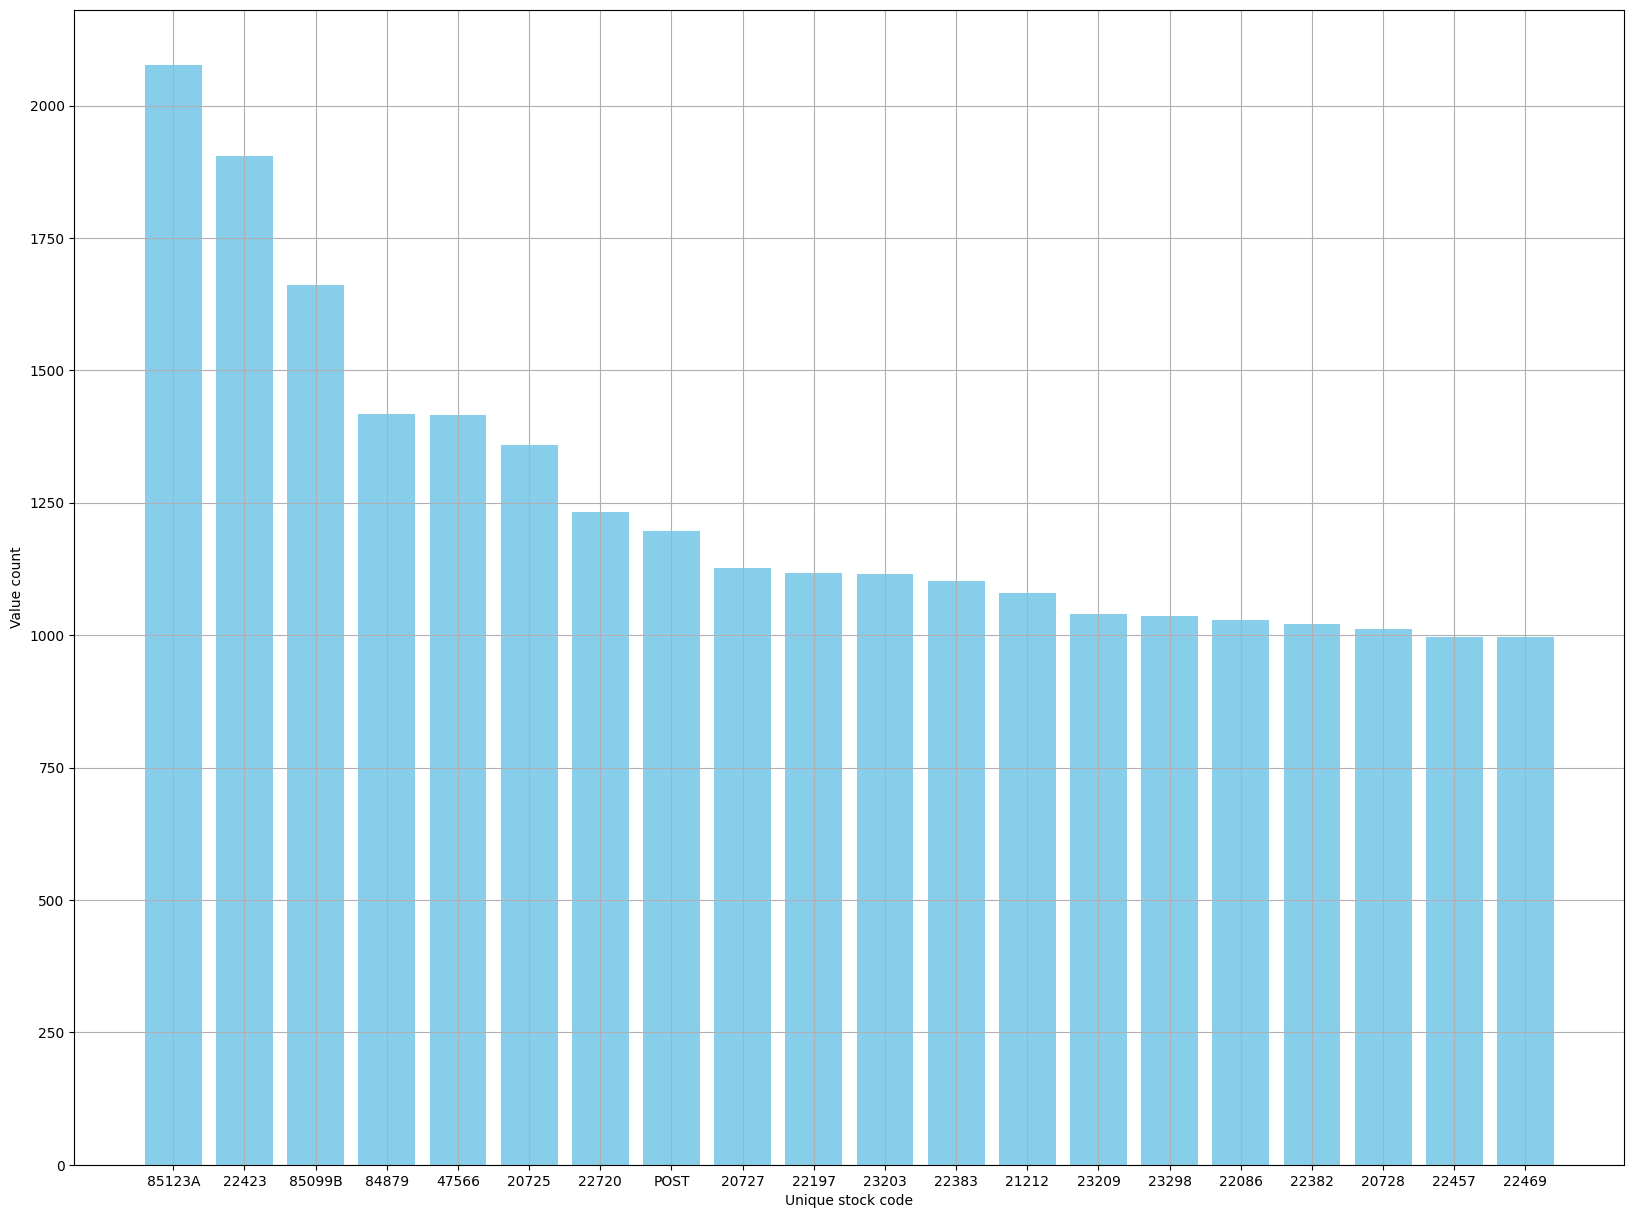

In [24]:
fig, ax = plt.subplots(1,1,figsize=(20,15))
plt.bar(stock_code_data.iloc[0:20].index,
            stock_code_data.iloc[0:20].values,
             color='skyblue')
plt.xlabel('Unique stock code')
plt.ylabel('Value count')
plt.grid(True)
plt.show()

Now lets try to figure out details regarding stock code other than which is popular

In [25]:
stock_code_len = np.array([])
for x in stock_code_data.index:
    stock_code_len = np.append(stock_code_len, len(x))


In [26]:
code, count = np.unique(stock_code_len, return_counts=True)


In [27]:
for x,y in zip(code, count):
    print(x,y)

1.0 2
2.0 1
3.0 1
4.0 3
5.0 2798
6.0 877
7.0 1
12.0 1


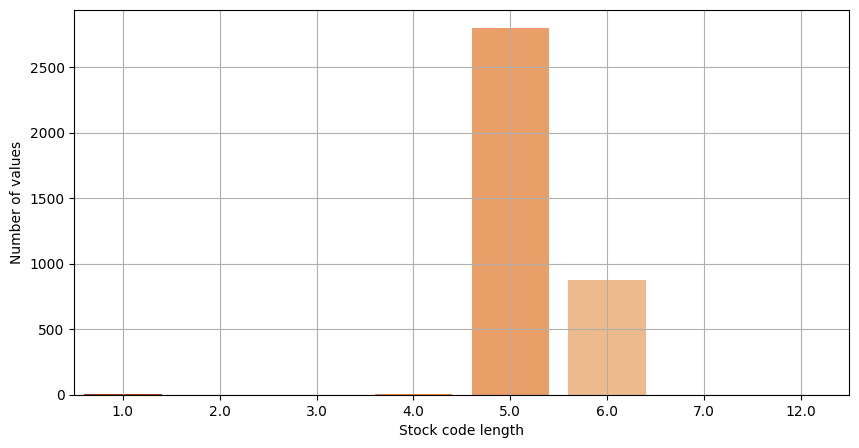

In [28]:
fig, axes = plt.subplots(1,1, figsize=(10,5))
sns.barplot(x=code,y=count,palette='Oranges_r', ax=axes)
ax.set_xlabel("Length of stockcode")
plt.xlabel('Stock code length')
plt.ylabel('Number of values')
plt.grid(True)

Lets see how many have stock code have alphabets.

In [29]:
only_digits = 0

for i in stock_code_data.index:
    if any(j.isalpha() for j in str(i)):
        only_digits += 1
print("Total % of codes that have alphabet are")
print(only_digits/len(stock_code_data.index)*100)

Total % of codes that have alphabet are
24.049945711183497


From above we can see that the common length of stock code is 5 and it ranges from 1-12, with 24% stock codes containing some type of alphabet. This means generally the stock codes are numbers.

Now let's try to get some details about description.

In [30]:
correct_data['Description'].nunique()

3896

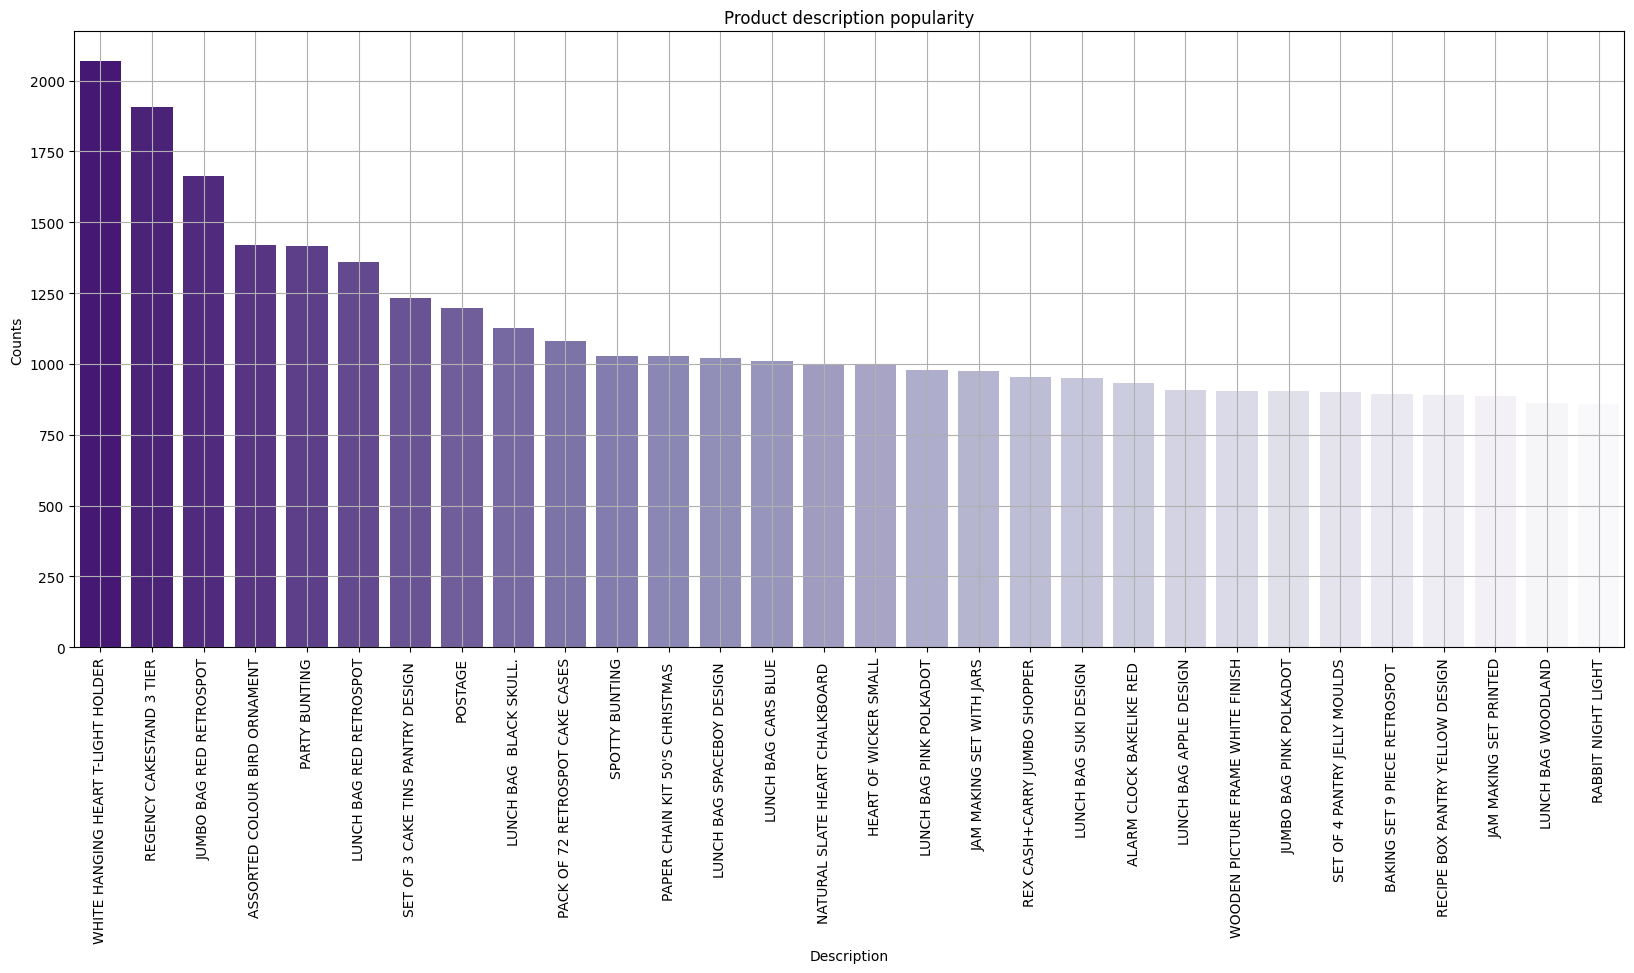

In [31]:
description_counts = correct_data.Description.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,8))
sns.barplot(x=description_counts.index, y=description_counts.values, palette="Purples_r")
plt.ylabel('Counts')
plt.title('Product description popularity')
plt.grid(visible=True)
plt.xticks(rotation=90);
plt.show()

In [66]:

correct_data["DescriptionLength"] = correct_data["Description"].str.len()

/tmp/ipykernel_33/4129008954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_data["DescriptionLength"] = correct_data["Description"].str.len()


In [67]:
description_len_data = correct_data["DescriptionLength"].sort_values(ascending=False).value_counts().iloc[0:30]
# description_len_data_asc = data["DescriptionLength"].sort_values(ascending=True).iloc[0:30]

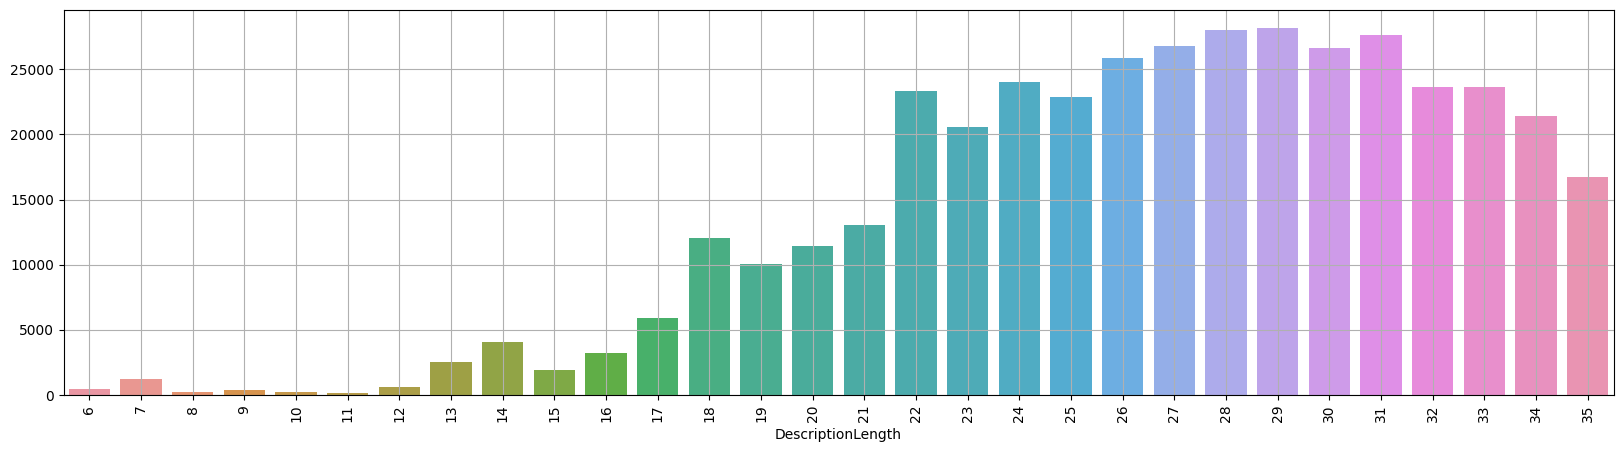

In [68]:
fig, ax = plt.subplots( figsize=(20,5))
sns.barplot(x=description_len_data.index, y=description_len_data.values)
# sns.barplot(x=description_len_data_asc.index, y=description_len_data_asc.values, ax=ax[1],palette="Purples_r")
# plt.ylabel('Description Length')
# plt.title('Length of Description')
# ax[1].set_yscale("log")

plt.grid(visible=True)
plt.xticks(rotation=90)
plt.show()

In [69]:
correct_data.DescriptionLength.describe()

count    406829.000000
mean         26.665439
std           5.385567
min           6.000000
25%          23.000000
50%          27.000000
75%          31.000000
max          35.000000
Name: DescriptionLength, dtype: float64

This shows that description between the range of 23-31 get most bought. And descriptions with lenght < 17 show less sales.

In [70]:
correct_data['Description'].nunique()

3896

In [71]:
correct_data.StockCode.nunique()

3684

Here we can see there are more number of unique description than unique stock code. Let's check why?

In [73]:
correct_data.groupby("StockCode").Description.nunique().sort_values(ascending=False).iloc[0:10]

StockCode
23236     4
23196     4
22776     3
23203     3
17107D    3
23413     3
23231     3
23396     3
23240     3
23126     3
Name: Description, dtype: int64

Here we can see same stock codes have different description.

In [75]:
correct_data.loc[correct_data.StockCode == '23236'].Description.value_counts()

Description
STORAGE TIN VINTAGE DOILY      181
DOILEY STORAGE TIN             118
DOILEY BISCUIT TIN              13
STORAGE TIN VINTAGE DOILEY       1
Name: count, dtype: int64

Here we can see the description of same stock is of 4 different types.

Let's work with customer id now and see the customer pattern

In [76]:
correct_data.CustomerID.nunique()

4372

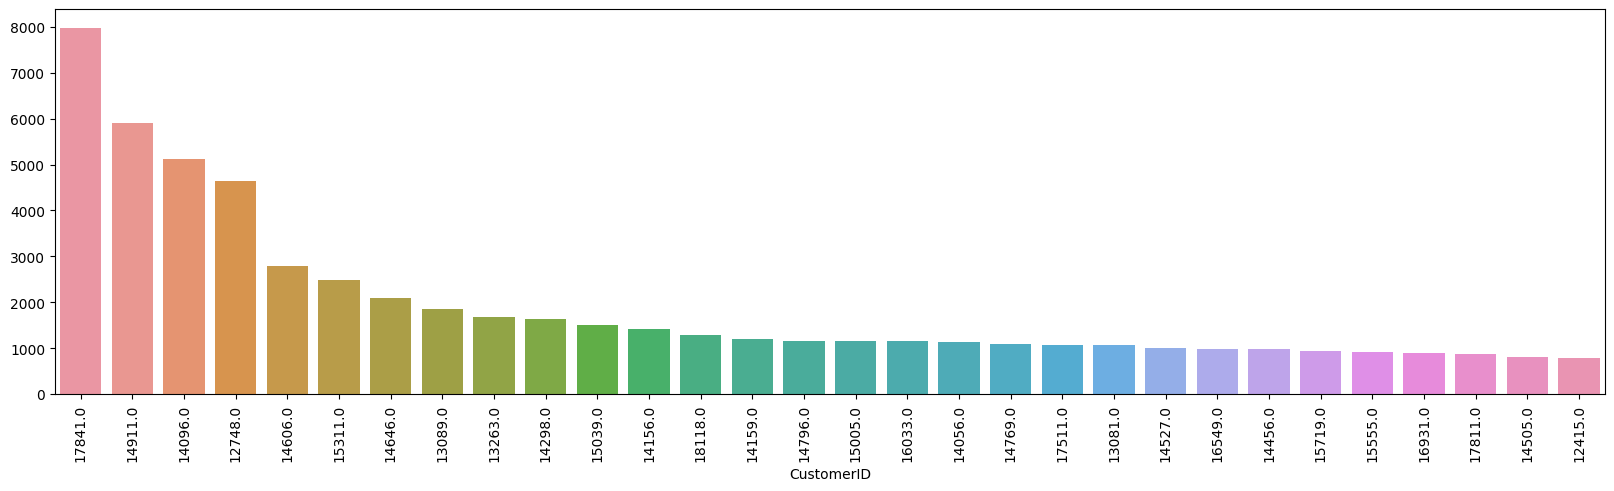

In [80]:
customer_counts = correct_data.CustomerID.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(x=customer_counts.index, y=customer_counts.values, order=customer_counts.index)
plt.xticks(rotation=90)
plt.show()

Here we can see the customer patten and figure out the important customers and rech out to the customers with potential growth.

Let's see the data in regards with different countries.

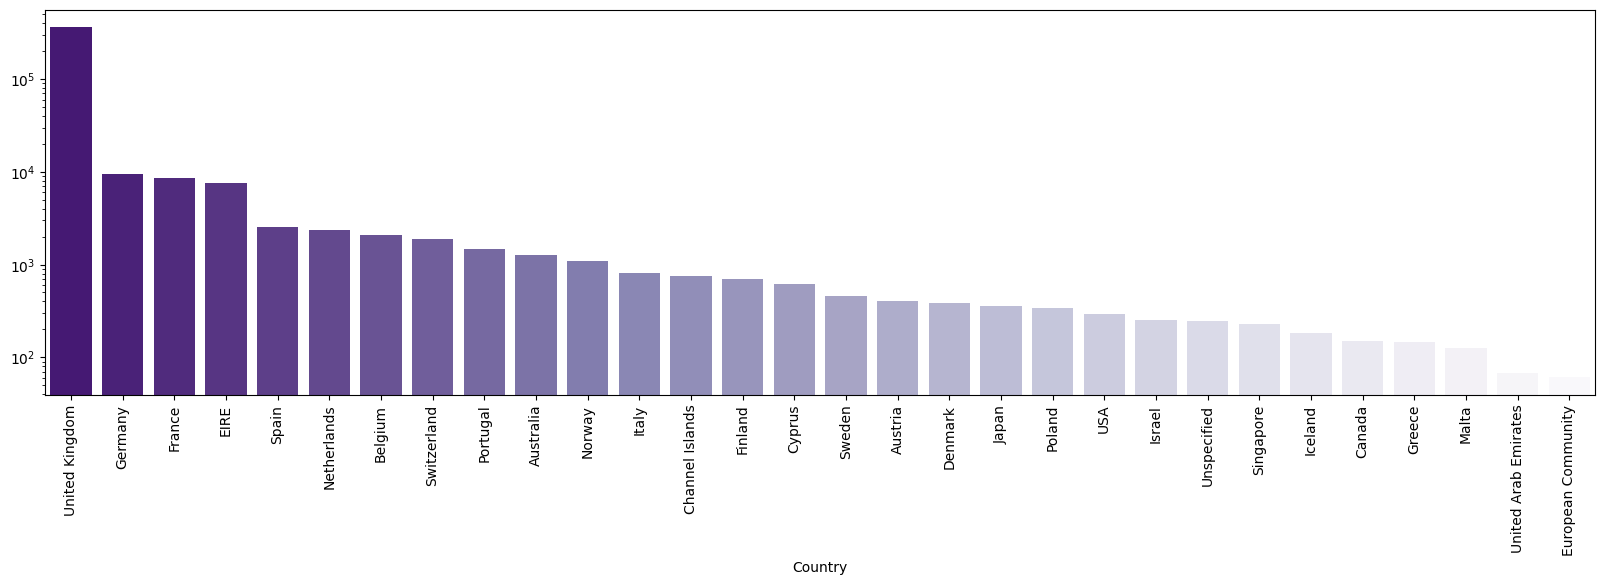

In [86]:
country_data = correct_data.Country.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(x=country_data.index, y=country_data.values, order=country_data.index, palette='Purples_r')
plt.xticks(rotation=90)
plt.yscale("log")
plt.show()

Let's see which country has most returns. It could be united kingdom as the sales are most there

In [92]:
return_data = correct_data[correct_data.Quantity < 0]

In [93]:
return_data.describe()

,Quantity,UnitPrice,CustomerID,DescriptionLength
count,8905.000000,8905.000000,8905.000000,8905.000000
mean,-30.859966,18.845519,14991.667266,26.141943
std,1170.154939,444.366043,1706.772357,6.361195
min,-80995.000000,0.010000,12346.000000,6.000000
25%,-6.000000,1.450000,13510.000000,23.000000
50%,-2.000000,2.950000,14895.000000,27.000000
75%,-1.000000,4.950000,16393.000000,31.000000
max,-1.000000,38970.000000,18282.000000,35.000000


In [96]:
return_data.Country.value_counts()


Country
United Kingdom        7533
Germany                453
EIRE                   247
France                 149
USA                    112
Australia               74
Spain                   48
Italy                   45
Belgium                 38
Japan                   37
Switzerland             35
Portugal                18
Malta                   15
Norway                  14
Poland                  11
Sweden                  11
Channel Islands         10
Finland                 10
Denmark                  9
Cyprus                   8
Netherlands              8
Singapore                7
Czech Republic           5
Austria                  3
Israel                   2
Saudi Arabia             1
European Community       1
Greece                   1
Name: count, dtype: int64

Lets check the trend with sales

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

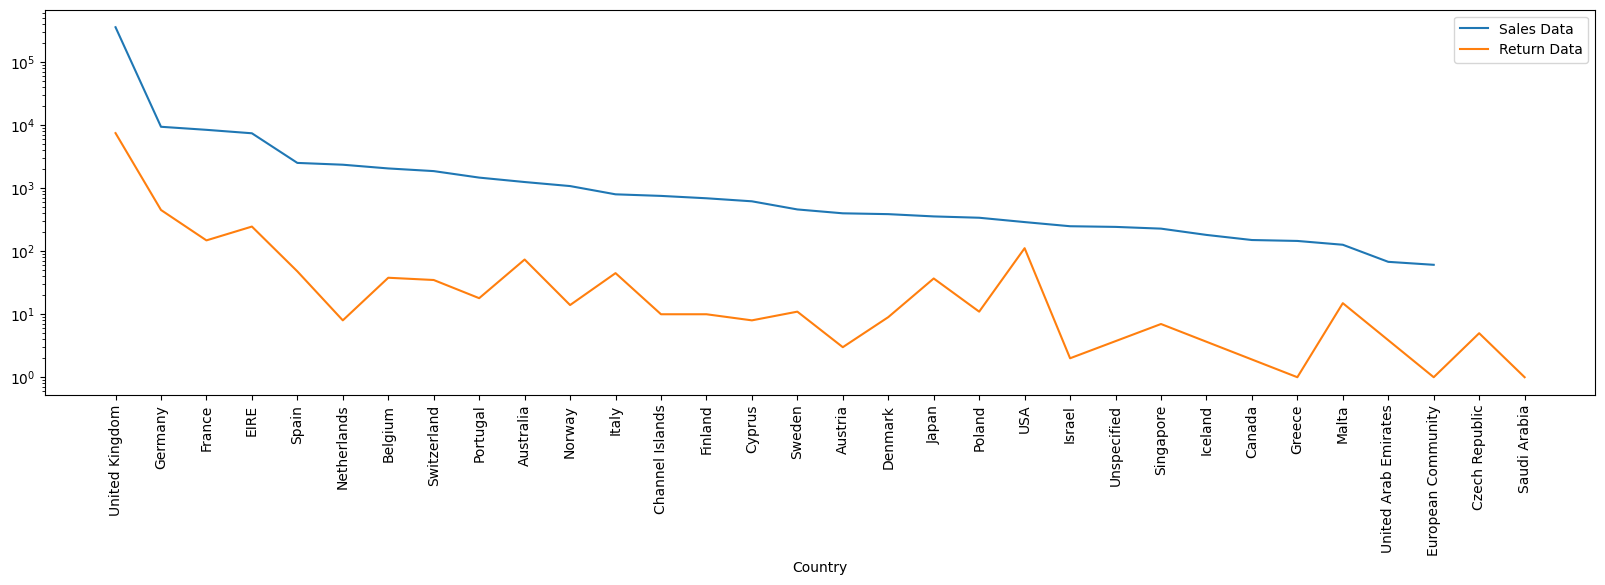

In [97]:
country_data = correct_data.Country.value_counts().sort_values(ascending=False).iloc[0:30]
return_data_plot = return_data.Country.value_counts()
plt.figure(figsize=(20,5))
sns.lineplot(x=country_data.index, y=country_data.values, label='Sales Data')
sns.lineplot(x=return_data_plot.index, y=return_data_plot.values, label='Return Data')
plt.xticks(rotation=90)
plt.yscale("log")
plt.legend()
plt.show()

As we can see Warnings regarding inf values. We get to know that there is issue with the data and we need to remove the inf values for better understanding.

As we can see most sales are done in UK. Lets try to disect the sales.

In [88]:
united_kingdom_data = correct_data[correct_data.Country == 'United Kingdom']

In [105]:
united_kingdom_data.describe()

,Quantity,UnitPrice,CustomerID,DescriptionLength
count,361878.000000,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,15547.871368,26.740125
std,263.129266,70.654731,1594.402590,5.286443
min,-80995.000000,0.000000,12346.000000,6.000000
25%,2.000000,1.250000,14194.000000,23.000000
50%,4.000000,1.950000,15514.000000,27.000000
75%,12.000000,3.750000,16931.000000,31.000000
max,80995.000000,38970.000000,18287.000000,35.000000


In [106]:
united_kingdom_data.Quantity


0          6
1          6
2          8
3          6
4          6
          ..
541889    12
541890     8
541891    24
541892    24
541893    10
Name: Quantity, Length: 361878, dtype: int64

In [107]:
united_kingdom_data[united_kingdom_data.Quantity==0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,DescriptionLength


In [109]:
united_kingdom_data[united_kingdom_data.UnitPrice==0].describe()

,Quantity,UnitPrice,CustomerID,DescriptionLength
count,24.000000,24.0,24.000000,24.000000
mean,530.500000,0.0,14811.708333,24.000000
std,2558.032668,0.0,1734.310776,8.500639
min,1.000000,0.0,12748.000000,6.000000
25%,1.000000,0.0,13105.000000,21.000000
50%,4.000000,0.0,14260.000000,27.000000
75%,17.000000,0.0,16201.250000,29.000000
max,12540.000000,0.0,18059.000000,35.000000


In [110]:
united_kingdom_data[united_kingdom_data.UnitPrice==0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,DescriptionLength
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,12/16/2010 14:36,0.0,16560.0,United Kingdom,False,28
47068,540372,22090,PAPER BUNTING RETROSPOT,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,False,23
47070,540372,22553,PLASTERS IN TIN SKULLS,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,False,22
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,1/13/2011 15:10,0.0,15107.0,United Kingdom,False,29
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2/10/2011 13:08,0.0,17560.0,United Kingdom,False,28


We can see unit prices are zero for above invoices. Let's see what are the total number for the same.

In [112]:
united_kingdom_data[united_kingdom_data.UnitPrice==0].Quantity.sum()

12732

let's figure out the percentage of items with unit price = 0 for all the data

In [114]:
correct_data[correct_data.UnitPrice==0].Quantity.sum()/correct_data.Quantity.sum()*100

0.28294919305270466

Let's move to daily sales

In [129]:
correct_data.loc[:,'InvoiceDate'] = pd.to_datetime(correct_data['InvoiceDate'])

In [132]:


correct_data.loc[:, "Revenue"] = correct_data.Quantity * correct_data.UnitPrice
correct_data.loc[:, "Year"] = correct_data.InvoiceDate.dt.year
correct_data.loc[:, "Quarter"] = correct_data.InvoiceDate.dt.quarter
correct_data.loc[:, "Month"] = correct_data.InvoiceDate.dt.month
correct_data.loc[:, "Week"] = correct_data.InvoiceDate.dt.isocalendar().week
correct_data.loc[:, "Weekday"] = correct_data.InvoiceDate.dt.weekday
correct_data.loc[:, "Day"] = correct_data.InvoiceDate.dt.isocalendar().day


In [140]:
correct_data.sort_values(by='Revenue', ascending=False).reset_index().head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,DescriptionLength,Revenue,Year,Quarter,Month,Week,Weekday,Day
0,540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,False,27,168469.60,2011,4,12,49,4,5
1,61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,False,30,77183.60,2011,1,1,3,1,2
2,222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,False,30,38970.00,2011,2,6,23,4,5
3,173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,False,7,8142.75,2011,2,5,18,1,2
4,348325,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450.0,United Kingdom,False,35,7144.72,2011,3,9,38,1,2


Here we can see the top items that make the most revenue.

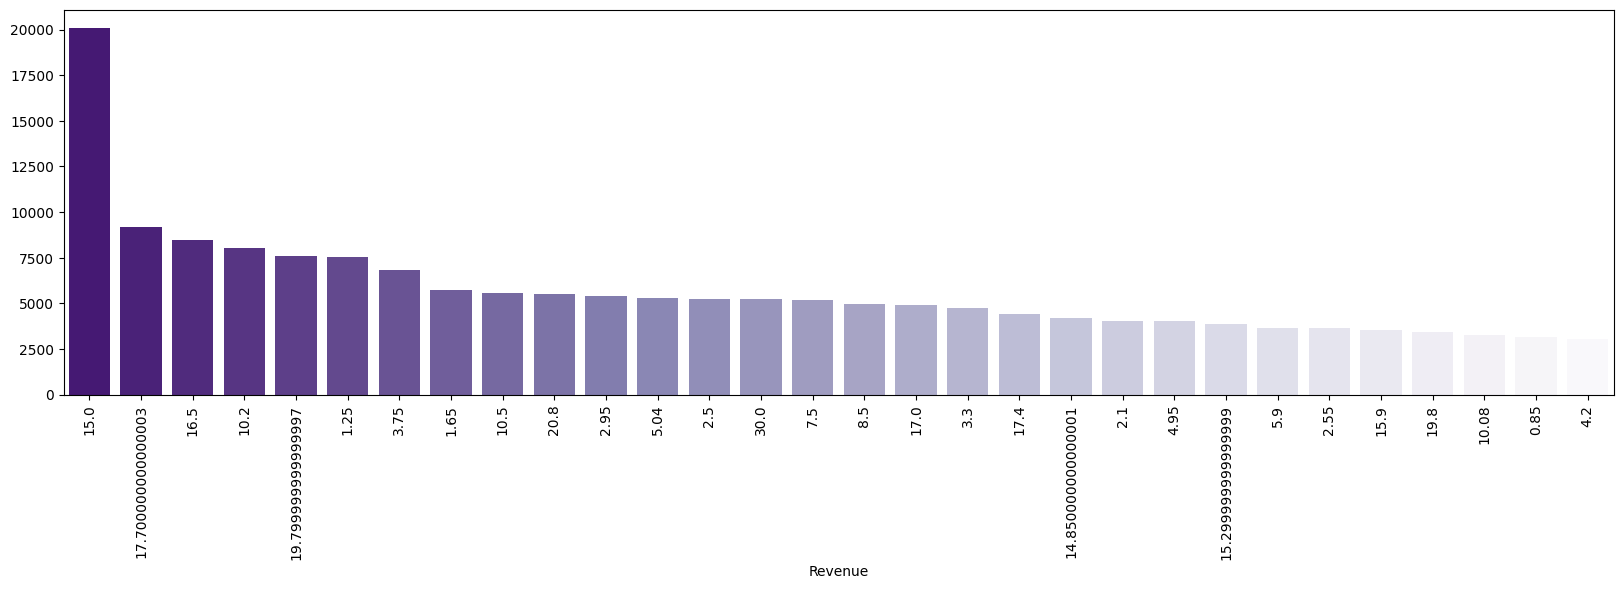

In [139]:
top_revenue_data = correct_data.sort_values(by='Revenue', ascending=False)['Revenue'].value_counts().iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(x=top_revenue_data.index, y=top_revenue_data.values, order=top_revenue_data.index, palette='Purples_r')
plt.xticks(rotation=90)
# plt.yscale("log")
plt.show()

From this we can see the sweet spot is 15 where we can get the maximum sales

In [141]:
correct_data.loc[:, ["Quantity", "Revenue"]].describe()

,Quantity,Revenue
count,406829.000000,406829.000000
mean,12.061303,20.401854
std,248.693370,427.591718
min,-80995.000000,-168469.600000
25%,2.000000,4.200000
50%,5.000000,11.100000
75%,12.000000,19.500000
max,80995.000000,168469.600000


Let's check which are popular days to shop.

In [173]:
day_data = correct_data.sort_values(by='Revenue', ascending=False).Day.value_counts()

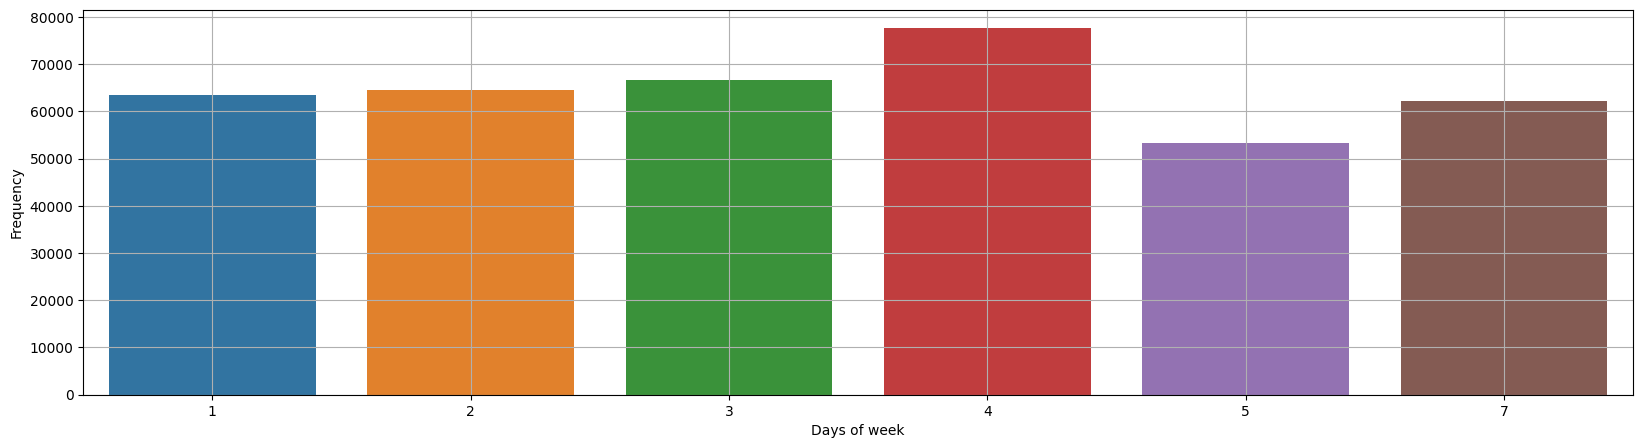

In [172]:
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x=day_data.index, y=day_data.values);
plt.xlabel('Days of week')
plt.ylabel('Frequency')
plt.grid(True)

Looks like Thursay is very popular and no one shops on saturday

Let's check which month is very popular

In [175]:
month_data = correct_data.sort_values(by='Revenue', ascending=False).Month.value_counts()

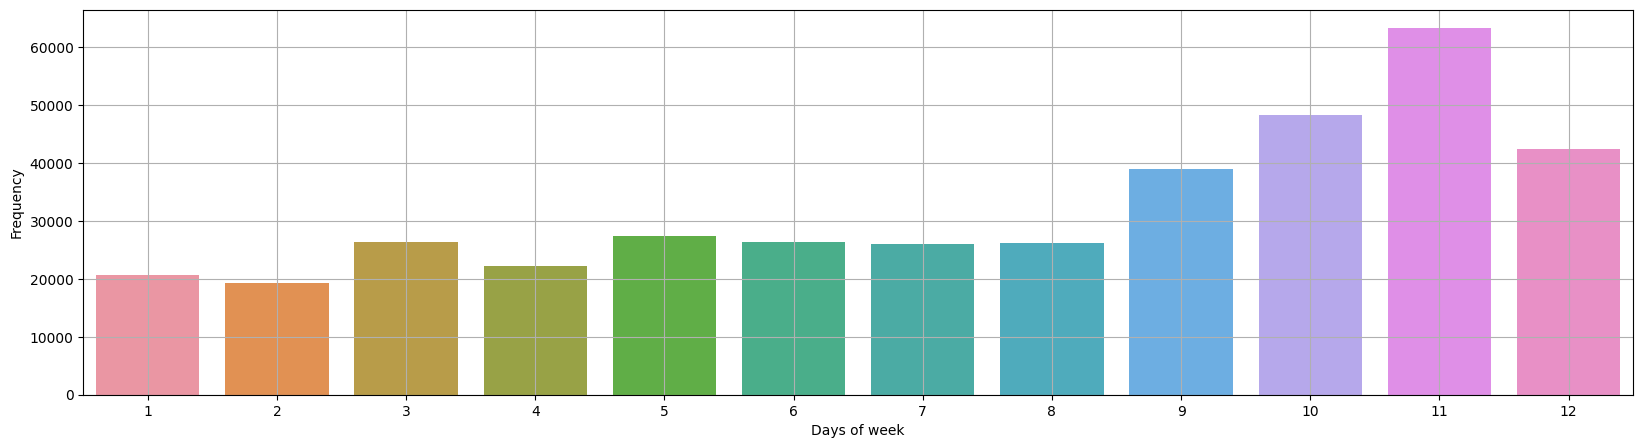

In [176]:
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x=month_data.index, y=month_data.values);
plt.xlabel('Days of week')
plt.ylabel('Frequency')
plt.grid(True)

Looks like November is the most popular month among shoppers.

In [180]:
november_data = correct_data.sort_values(by='Revenue', ascending=False)[correct_data.Month == 11]

/tmp/ipykernel_33/4195214014.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  november_data = correct_data.sort_values(by='Revenue', ascending=False)[correct_data.Month == 11]


In [183]:
november_data.head().reset_index()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,DescriptionLength,Revenue,Year,Quarter,Month,Week,Weekday,Day
0,434017,574023,23083,SET 6 PAPER TABLE LANTERN STARS,36,2011-11-02 12:20:00,3.75,14390.0,United Kingdom,False,32,135.0,2011,4,11,44,2,3
1,431993,573778,21484,CHICK GREY HOT WATER BOTTLE,36,2011-11-01 10:56:00,3.75,18092.0,United Kingdom,False,27,135.0,2011,4,11,44,1,2
2,431991,573778,22113,GREY HEART HOT WATER BOTTLE,36,2011-11-01 10:56:00,3.75,18092.0,United Kingdom,False,27,135.0,2011,4,11,44,1,2
3,509581,579364,23083,SET 6 PAPER TABLE LANTERN STARS,36,2011-11-29 11:52:00,3.75,14173.0,United Kingdom,False,32,135.0,2011,4,11,48,1,2
4,439009,574349,22113,GREY HEART HOT WATER BOTTLE,36,2011-11-04 10:29:00,3.75,13495.0,United Kingdom,False,27,135.0,2011,4,11,44,4,5


In [186]:
november_days_data = november_data.Day.value_counts()

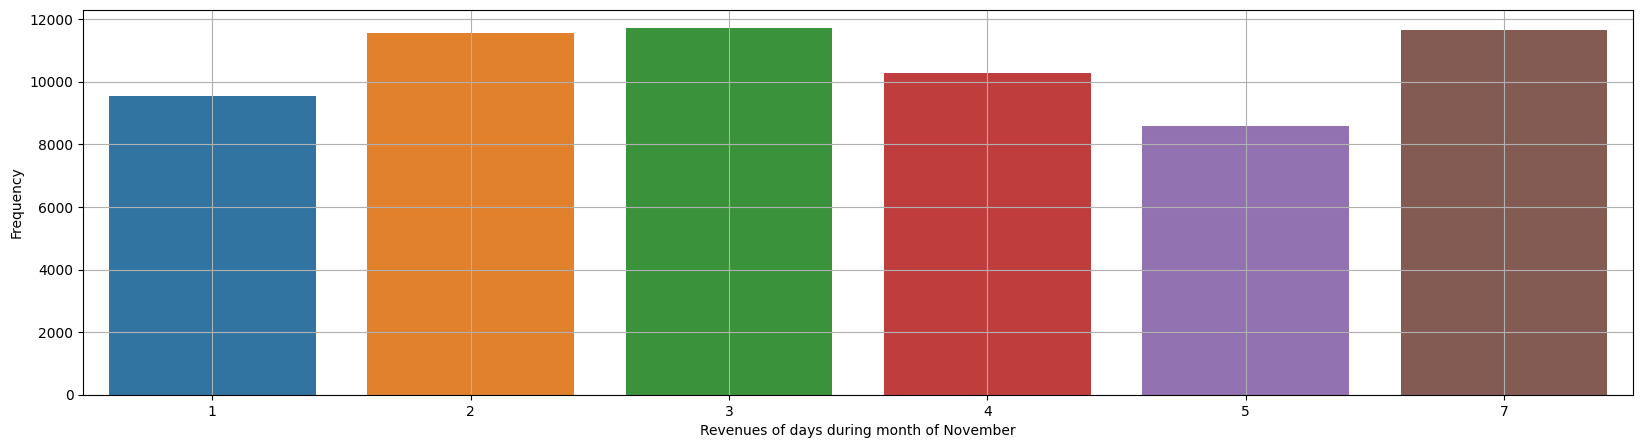

In [188]:
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x=november_days_data.index, y=november_days_data.values);
plt.xlabel('Revenues of days during month of November')
plt.ylabel('Frequency')
plt.grid(True)

Looks like Wednesday and Sunday are more popular during November as opposed to Thursday during the whole year.

In [193]:
november_data.StockCode.value_counts()

StockCode
23084     441
22086     341
23355     267
22910     230
23344     227
         ... 
20848       1
23449       1
90019C      1
90206A      1
17038       1
Name: count, Length: 2683, dtype: int64

In [195]:
november_stock_data = november_data.StockCode.value_counts().iloc[0:30]

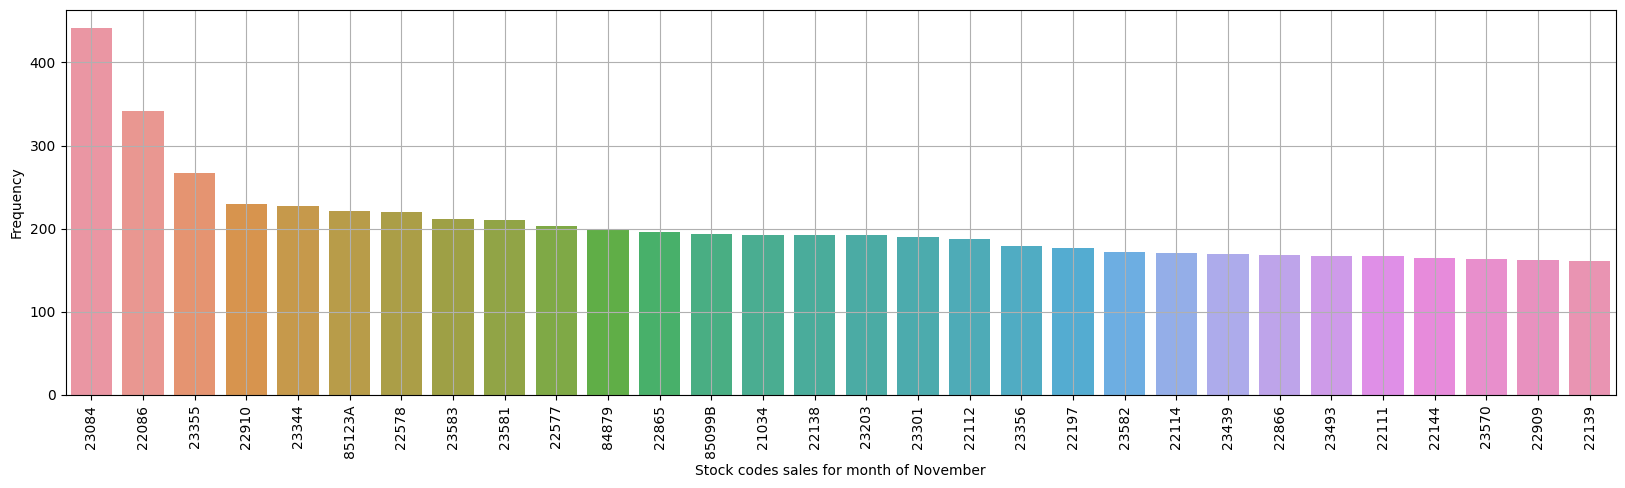

In [197]:
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x=november_stock_data.index, y=november_stock_data.values);
plt.xlabel('Stock codes sales for month of November')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.grid(True)

Looks like product code 23084 is very popular during month of November.

In [198]:
stock_data = correct_data.StockCode.value_counts().iloc[0:30]

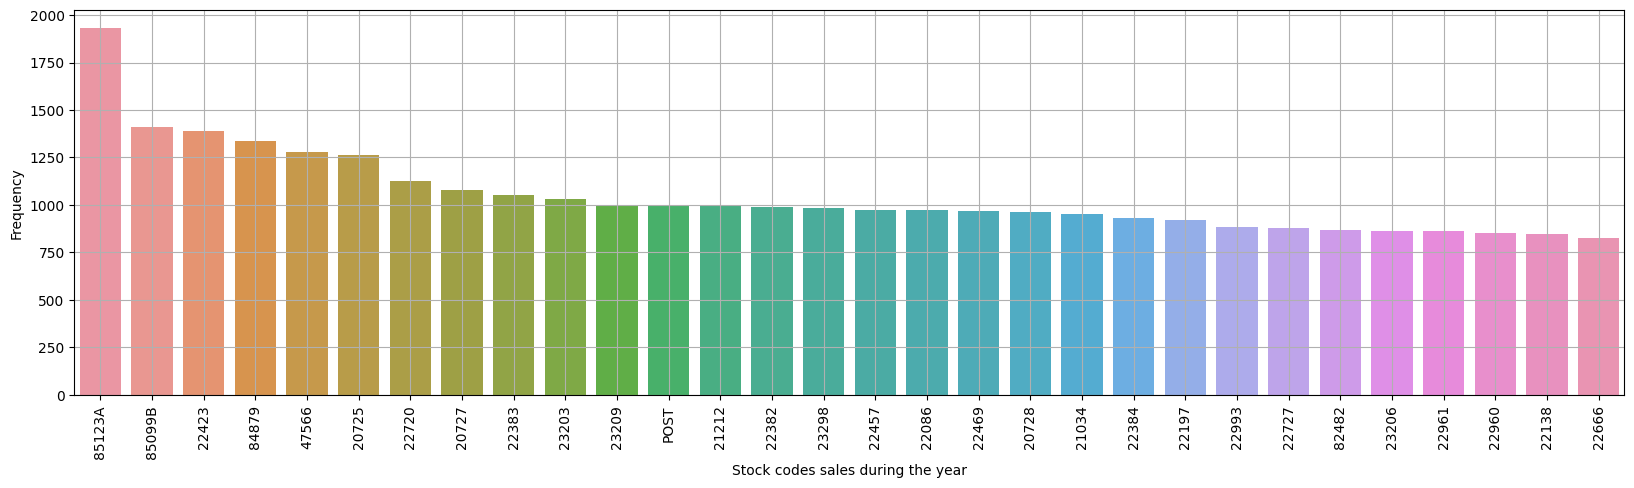

In [200]:
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x=stock_data.index, y=stock_data.values);
plt.xlabel('Stock codes sales during the year')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.grid(True)

Looks like stock code 85123A is popular during the year opposed to code 23084 during the month of November.

Now let's move to Preprocessing of data and start removing outliers

In [148]:
low_revenue = correct_data.Revenue.quantile(0.01) 
high_revenue = correct_data.Revenue.quantile(0.99) 
low_quantity = correct_data.Quantity.quantile(0.01) 
high_quantity = correct_data.Quantity.quantile(0.99)

In [151]:
correct_data = correct_data.loc[(correct_data.Revenue >= low_revenue) & 
                                (correct_data.Revenue <= high_revenue)]

In [152]:
correct_data = correct_data.loc[(correct_data.Quantity >= low_quantity) & 
                                (correct_data.Quantity <= high_quantity)]

In [160]:
correct_data = correct_data[~np.isinf(correct_data['Revenue'])]

In [161]:
correct_data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,DescriptionLength,Revenue,Year,Quarter,Month,Week,Weekday,Day
count,387774.000000,387774,387774.000000,387774.000000,387774.000000,387774.000000,387774.000000,387774.000000,387774.000000,387774.0,387774.000000,387774.000000
mean,8.816321,2011-07-11 04:59:41.308700672,2.891117,15298.975083,26.702667,15.276648,2010.934165,2.859031,7.620722,30.999474,2.623515,3.623515
min,1.000000,2010-12-01 08:26:00,0.000000,12347.000000,6.000000,0.000000,2010.000000,1.000000,1.000000,1.0,0.000000,1.000000
25%,2.000000,2011-04-07 11:30:00,1.250000,13969.000000,23.000000,4.350000,2011.000000,2.000000,5.000000,19.0,1.000000,2.000000
50%,5.000000,2011-07-31 15:26:00,1.950000,15159.000000,27.000000,10.750000,2011.000000,3.000000,8.000000,35.0,2.000000,3.000000
75%,12.000000,2011-10-21 09:25:00,3.750000,16801.000000,31.000000,17.850000,2011.000000,4.000000,11.000000,44.0,4.000000,5.000000
max,98.000000,2011-12-09 12:50:00,134.000000,18287.000000,35.000000,135.000000,2011.000000,4.000000,12.000000,51.0,6.000000,7.000000
std,11.341170,NaN,3.426647,1711.950618,5.341024,17.092712,0.247993,1.122127,3.417799,14.761362,1.936007,1.936007


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


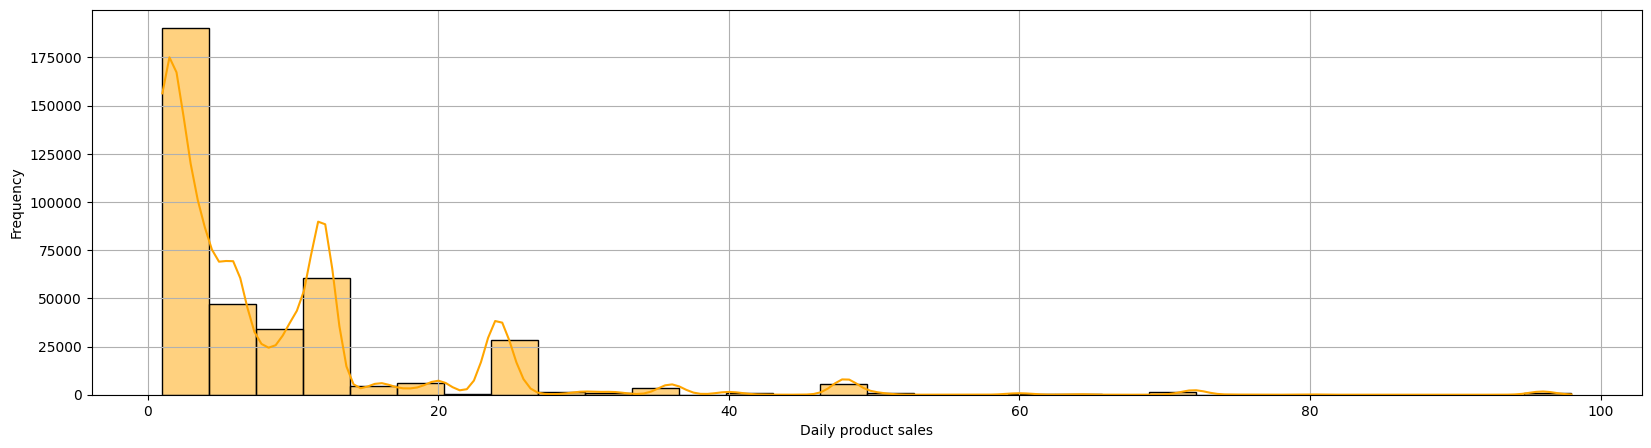

In [165]:
fig, ax = plt.subplots(figsize=(20,5))
sns.histplot(correct_data.Quantity.values, kde=True, color="Orange", bins=30);
plt.xlabel('Daily product sales')
plt.ylabel('Frequency')
plt.grid(True)


We can see the lower quantities are popular during purchase

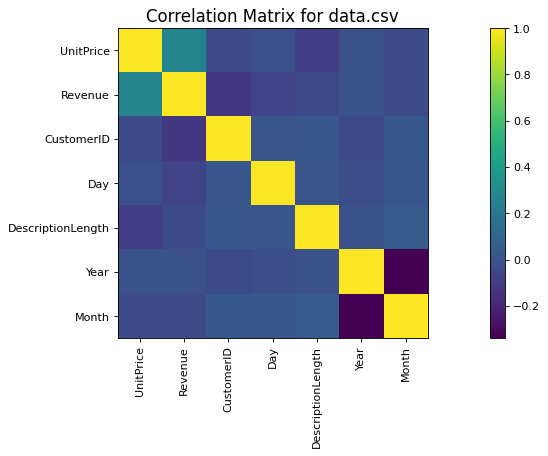

In [206]:

corr = correct_data[['UnitPrice','Revenue','CustomerID','Day', 'DescriptionLength','Year','Month']].corr()
plt.figure(num=None, figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')
corrMat = plt.matshow(corr, fignum = 1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.gca().xaxis.tick_bottom()
plt.colorbar(corrMat)
plt.title(f'Correlation Matrix for {filename}', fontsize=15)
plt.show()